# Bayesian inference in a multivariate Gaussian model using natural exponential families and JAX
_Scott Linderman_

_Nov 18, 2021_

---

Recall the normal inverse Wishart (NIW) from our [previous post](https://colab.research.google.com/github/lindermanlab/hackathons/blob/master/notebooks/TFP_Normal_Inverse_Wishart.ipynb). It's a conjugate prior for a multivariate Gaussian with unknown mean and covariance, and it is defined by a two-step generative process,
\begin{align}
\Sigma &\sim \mathrm{IW}(\nu, \Psi) \\
\mu \mid \Sigma &\sim \mathcal{N}(\mu_0, \kappa^{-1} \Sigma)
\end{align}

Last time we implemented the NIW distribution using Tensorflow probability's `JointDistribution` and `Bijector` objects. Now we'll use it to perform inference in a simple multivariate normal model. In doing so, we'll demonstrate some nice exponential family distribution concepts that make inference super easy!

## Bayesian inference in a simple Gaussian model

Consider a simple Gaussian model,
\begin{align}
\mu, \Sigma &\sim \mathrm{NIW}(\mu_0, \kappa, \nu, \Psi) \\
x_n &{\stackrel{\text{iid}}{\sim}} \mathcal{N}(\mu, \Sigma) & \text{for } n = 1,\ldots, N
\end{align}
The posterior $p(\mu, \Sigma \mid\{x_n\}_{n=1}^N)$ is also a NIW (since its a conjugate prior), and its parameters are determined by summing the sufficient statistics of the Gaussian likelihood with the natural parameters of the prior.

How do we get the parameters of the NIW posterior? Often, you look it up in a [table on Wikipedia](https://en.wikipedia.org/wiki/Conjugate_prior#When_likelihood_function_is_a_continuous_distribution), but I'm here to tell you there's a better (or at least more general) way. The trick is to cast the prior and likelihood in their natural exponential family form.

Let's start by unpacking the NIW prior,
\begin{align}
p(\mu, \Sigma \mid \mu_0, \kappa, \nu, \Psi) &= \mathrm{IW}(\Sigma \mid \nu, \Psi) \, \mathcal{N}(\mu \mid \mu_0, \kappa^{-1} \Sigma) \\
&\propto |\Sigma|^{-(\nu + D + 1)/2} \exp\{-\tfrac{1}{2} \mathrm{Tr}(\Psi \Sigma^{-1}) \} \, 
|\kappa^{-1} \Sigma|^{-1/2} \exp\left\{ -\tfrac{\kappa}{2} (\mu - \mu_0)^\top \Sigma^{-1} (\mu - \mu_0)\right\} \\
&\propto 
\exp\left\{ 
    \langle -\tfrac{1}{2} \log |\Sigma|, \nu + D + 2 \rangle
    + \langle \Sigma^{-1} \mu, \kappa \mu_0 \rangle 
    + \langle -\tfrac{1}{2} \Sigma^{-1}, \Psi + \kappa \mu_0\mu_0^\top \rangle 
    + \langle -\tfrac{1}{2}\mu^\top \Sigma^{-1} \mu, \kappa \rangle 
\right \} \\
&\propto 
\exp \left\{ \sum_{i=1}^4 \langle \eta_i, \chi_i \rangle \right \}
\end{align}
Its density is an exponentiated sum of inner products between the **prior sufficient statistics**
\begin{align}
\eta_1 &= -\tfrac{1}{2} \log |\Sigma| \\
\eta_2 &=\Sigma^{-1} \mu \\
\eta_3 &= -\tfrac{1}{2} \Sigma^{-1} \\
\eta_4 &= -\tfrac{1}{2} \mu^\top \Sigma^{-1} \mu
\end{align}
and the **natural parameters** 
\begin{align}
\chi_1 &= \nu + D + 2 \\
\chi_2 &= \kappa \mu_0 \\
\chi_3 &= \Psi + \kappa  \mu_0 \mu_0^\top \\
\chi_4 &= \kappa
\end{align}

Now compare this to the multivariate Gaussian likelihood,
\begin{align}
p(x \mid \mu, \Sigma) &=
\frac{1}{(2\pi)^{D/2}} |\Sigma|^{-1/2} 
\exp\left\{ -\tfrac{1}{2} (x-\mu)^\top \Sigma^{-1} (x-\mu) \right\}\\
&\propto
\exp\left\{ 
    \langle -\tfrac{1}{2} \log |\Sigma|, 1 \rangle
    + \langle \Sigma^{-1} \mu, x \rangle 
    + \langle -\tfrac{1}{2} \Sigma^{-1}, xx^\top \rangle 
    + \langle -\tfrac{1}{2}\mu^\top \Sigma^{-1} \mu, 1 \rangle 
\right \} \\
&\propto
\exp\left\{ \sum_{i=1}^4 \langle \eta_i, t_i(x) \rangle \right \} \\ 
\end{align}
where
\begin{align}
    t_1(x) &= 1 \\
    t_2(x) &= x \\
    t_3(x) &= xx^\top \\
    t_4(x) &= 1
\end{align}
We see the same functional form: an exponentiated sum of inner products where the sufficient statistics of the prior have are the same as the natural parameters of the likelihood. Here, those parameters are weighted by **sufficient statistics of the data** $t_i(x)$. 

The posterior is proportional to the prior times the likelihood, and since both are now in natural exponential family form, the terms in the exponent simply add up to give,
\begin{align}
p(\mu, \Sigma \mid \{x_n\}_{n=1}^N, \mu_0, \kappa, \nu, \Psi) 
&\propto \mathrm{NIW}(\mu, \Sigma  \mid \mu_0, \kappa, \nu, \Psi) \, \prod_{n=1}^N \mathcal{N}(x_n \mid \mu, \Sigma) \\
&\propto 
\exp \left\{
    \sum_{i=1}^4 \left \langle \eta_i, \chi_i + \sum_{n=1}^N t_i(x_n) \right \rangle 
    \right\}
\end{align}
We recognize this as another NIW distribution but with natural parameters $\chi_i + \sum_{n=1}^N t_i(x_n)$. 

Finally, how do we convert the natural parameters of the posterior into the standard parameters of a NIW distribution? Note that the mapping between natural parameters $(\chi_1, \chi_2, \chi_3, \chi_4)$ and standard parameters $(\mu_0, \kappa, \nu, \Psi)$ is invertible. That's because the NIW is a minimal exponential family. We simply have to do a little algebra to convert from one to the other. 

Let's see it in code!

In [1]:
import jax.numpy as np
import jax.random as jr
from jax import vmap
from jax.tree_util import tree_map
import tensorflow_probability.substrates.jax as tfp
import matplotlib.pyplot as plt
from functools import partial

tfd = tfp.distributions
tfb = tfp.bijectors

## Implementing the `NormalInverseWishart` distribution with some exponential family helpers
Let's start by copying our `NormalInverseWishart` distribution object from the [previous post](). We'll add two helper functions:
- `natural_parameters`: a property that converts the standard parameters to the natural parameters and returns them as a tuple.
- `from_natural_parameters`: a class method that constructs a `NormalInverseWishart` object using its natural parameters.

In [2]:
class NormalInverseWishart(tfd.JointDistributionNamed):
    def __init__(self, loc, mean_precision, df, scale, **kwargs):
        """
        A normal inverse Wishart (NIW) distribution with

        Args:
            loc:            \mu_0 in math above
            mean_precision: \kappa_0 
            df:             \nu
            scale:          \Psi 

        Returns: 
            A tfp.JointDistribution object.
        """
        # Store hyperparameters. 
        self._loc = loc
        self._mean_precision = mean_precision
        self._df = df
        self._scale = scale
        
        # Convert the inverse Wishart scale to the scale_tril of a Wishart.
        # Note: this could be done more efficiently.
        self.wishart_scale_tril = np.linalg.cholesky(np.linalg.inv(scale))

        super(NormalInverseWishart, self).__init__(dict(
            Sigma=lambda: tfd.TransformedDistribution(
                tfd.WishartTriL(df, scale_tril=self.wishart_scale_tril),
                tfb.Chain([tfb.CholeskyOuterProduct(),                 
                        tfb.CholeskyToInvCholesky(),                
                        tfb.Invert(tfb.CholeskyOuterProduct())
                        ])),
            mu=lambda Sigma: tfd.MultivariateNormalFullCovariance(
                loc, Sigma / mean_precision)
        ))

        # Replace the default JointDistributionNamed parameters with the NIW ones
        # because the JointDistributionNamed parameters contain lambda functions,
        # which are not jittable.
        self._parameters = dict(
            loc=loc,
            mean_precision=mean_precision,
            df=df,
            scale=scale
        )

    # These functions compute the pseudo-observations implied by the NIW prior
    # and convert sufficient statistics to a NIW posterior. We'll describe them
    # in more detail below.
    @property
    def natural_parameters(self):
        """Compute pseudo-observations from standard NIW parameters."""
        dim = self._loc.shape[-1]
        chi_1 = self._df + dim + 2
        chi_2 = np.einsum('...,...i->...i', self._mean_precision, self._loc)
        chi_3 = self._scale + self._mean_precision * \
            np.einsum("...i,...j->...ij", self._loc, self._loc)
        chi_4 = self._mean_precision
        return chi_1, chi_2, chi_3, chi_4

    @classmethod
    def from_natural_parameters(cls, natural_params):
        """Convert natural parameters into standard parameters and construct."""
        chi_1, chi_2, chi_3, chi_4 = natural_params
        dim = chi_2.shape[-1]
        df = chi_1 - dim - 2
        mean_precision = chi_4
        loc = np.einsum('..., ...i->...i', 1 / mean_precision, chi_2)
        scale = chi_3 - mean_precision * np.einsum('...i,...j->...ij', loc, loc)
        return cls(loc, mean_precision, df, scale)

    def _mode(self):
        r"""Solve for the mode. Recall,
        .. math::
            p(\mu, \Sigma) \propto
                \mathrm{N}(\mu | \mu_0, \Sigma / \kappa_0) \times
                \mathrm{IW}(\Sigma | \nu_0, \Psi_0)
        The optimal mean is :math:`\mu^* = \mu_0`. Substituting this in,
        .. math::
            p(\mu^*, \Sigma) \propto IW(\Sigma | \nu_0 + 1, \Psi_0)
        and the mode of this inverse Wishart distribution is at
        .. math::
            \Sigma^* = \Psi_0 / (\nu_0 + d + 2)
        """
        dim = self._loc.shape[-1]
        covariance = np.einsum("...,...ij->...ij", 
                               1 / (self._df + dim + 2), self._scale)
        return self._loc, covariance


## Wrapping the MultivariateNormal with exponential family helpers

In [3]:
class MultivariateNormalFullCovariance(tfd.MultivariateNormalFullCovariance):
    """
    This wrapper adds simple functions to get sufficient statistics and 
    construct a MultivariateNormalFullCovariance from parameters drawn
    from the normal inverse Wishart distribution.
    """
    @classmethod
    def from_parameters(cls, params, **kwargs):
        return cls(*params, **kwargs)

    @staticmethod
    def sufficient_statistics(datapoint):
        return (1.0, datapoint, np.outer(datapoint, datapoint), 1.0)


## Sample some data

In [4]:
# Sample the generative model.
num_datapoints = 100
dim = 2
params = dict(
    loc=np.zeros(dim),
    mean_precision=1.0,
    df=dim + 3,
    scale=np.eye(dim)
)

seed1, seed2 = jr.split(jr.PRNGKey(0), 2)
niw = NormalInverseWishart(**params)
smpl = niw.sample(seed=seed1)
mvn = tfd.MultivariateNormalFullCovariance(smpl["mu"], smpl["Sigma"])
data = mvn.sample(seed=seed2, sample_shape=(num_datapoints,))

## This is where the magic happens
JAX makes it extremely easy to be Bayesian. Collecting sufficient statistics and summing them up is a simple application of `vmap` and `tree_map`. The result is just so clean!

In [5]:
# Collect sufficient statistics from each data point and sum them up.
stats = tree_map(
    partial(np.sum, axis=0), 
    vmap(MultivariateNormalFullCovariance.sufficient_statistics)(data))

# Add the natural parameters of the prior.
stats = tree_map(np.add, stats, niw.natural_parameters)
    
# Compute the posterior distribution over parameters
posterior = NormalInverseWishart.from_natural_parameters(stats)

Now we'll sample the posterior multiple times to collect multiple samples of the mean and covariance, $\{\mu_j, \Sigma_j\}_{j=1}^J$. We'll plot the conditional distribution $p(x \mid \mu_j, \Sigma_j)$ for each sample to get a sense for how much uncertainty there is in the Gaussian distribution given the data.

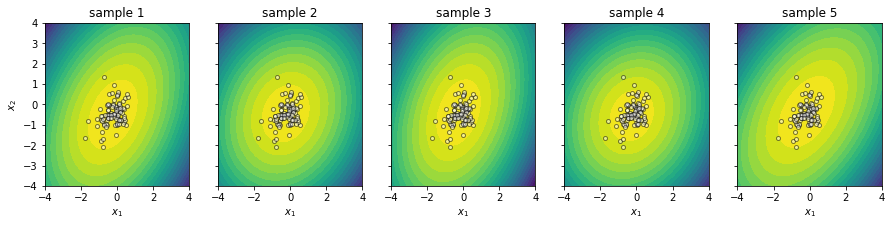

In [6]:
# Draw samples of (\mu, \Sigma) from the posterior and plot the contours 
# of p(x \mid \mu, \Sigma) for each one.
n_samples = 5
seed = jr.PRNGKey(0)

n_pts = 50
x1s, x2s = np.meshgrid(
    np.linspace(-4, 4, n_pts),
    np.linspace(-4, 4, n_pts)
)

fig, axs = plt.subplots(1, n_samples, figsize=(n_samples * 3, 3), sharey=True)
for i, ax in enumerate(axs):
    seed, this_seed = jr.split(seed, 2)
    smpl = posterior.sample(seed=this_seed)
    mvn = tfd.MultivariateNormalFullCovariance(smpl["mu"], smpl["Sigma"])
    lps = mvn.log_prob(np.column_stack([x1s.ravel(), x2s.ravel()]))
    
    ax.contourf(x1s, x2s, lps.reshape(n_pts, n_pts), 25)
    ax.plot(data[:, 0], data[:, 1], 'wo', ms=4, mec='k', alpha=0.5)
    ax.set_xlabel("$x_1$")
    if i == 0: ax.set_ylabel("$x_2$")
    ax.set_title("sample {}".format(i+1))

## Maximum a posteriori (MAP) estimation

Since we implemented the `_mode` function for `NormalInverseWishart` we can get the MAP estimate of the parameters by simpling using `posterior.mode()`. 

Note that the MAP estimate should have slightly smaller mean and covariance that the MLE due to the influence of the prior.

In [8]:
# Get the maximum a posteriori estimate of the multivariate normal
mvn_map_estimate = \
    MultivariateNormalFullCovariance.from_parameters(posterior.mode())

print("True mean:\n", mvn.mean().round(2))
print("MAP mean:\n", mvn_map_estimate.mean().round(2))
print("Empirical mean:\n", data.mean(axis=0).round(2))
print("\n")
print("True covariance:\n", mvn.covariance().round(2))
print("MAP covariance:\n", mvn_map_estimate.covariance().round(2))
print("Empirical covariance:\n", np.cov(data, rowvar=False).round(2))

True mean:
 [-0.17       -0.35999998]
MAP mean:
 [-0.21 -0.44]
Empirical mean:
 [-0.22 -0.45]


True covariance:
 [[0.26999998 0.14      ]
 [0.14       0.34      ]]
MAP covariance:
 [[0.19999999 0.08      ]
 [0.08       0.29999998]]
Empirical covariance:
 [[0.21 0.09]
 [0.09 0.32]]


## Conclusion

Tensorflow probability offers lots of great tools for building probabilistic models. In general, their library of distributions is top notch! One omission is the normal inverse Wishart distribution, an important conjugate prior for multivariate Gaussian models. This notebook implements it as a `JointDistribution` and shows how to cast the multivariate normal and NIW in their natural exponential family form, where Bayesian inference is as simple as summing sufficient statistics and converting between natural and standard parameters. 

If you want to dig deeper, think about how you would implement the [matrix normal](https://en.wikipedia.org/wiki/Matrix_normal_distribution) inverse Wishart (MNIW) using the TFP [`MatrixNormalLinearOperator`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MatrixNormalLinearOperator) object. It's the conjugate prior for a Bayesian linear regression. What are its natural parameters and how do they compare to those of the NIW distribution?